# Analyse BlueSeis BSPF Events

In [1]:
import os
import obspy as obs

from obspy.clients.fdsn import Client

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [24]:
config = {}

## output path for figures
config['path_to_figs'] = data_path+"BSPF/figures/M62_event/"


## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## Eventtime
config['eventtime'] = obs.UTCDateTime("2022-11-22 16:32:00")

## Event M62
config['tbeg'] = obs.UTCDateTime("2022-11-22 16:38:00")
config['tend'] = obs.UTCDateTime("2022-11-22 16:45:00")

config['fmin'] = 0.1
config['fmax'] = 1.0

## Load Data

In [25]:
event = Client("USGS").get_events(starttime=config['tbeg'],endtime=config['tend'],minmagnitude=6.0)
event = event[0]

In [26]:
st0 = obs.read("./event62_6C.mseed")

st0.resample(40)

6 Trace(s) in Stream:
PY.BSPF..HJE  | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
PY.BSPF..HJN  | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
PY.BSPF..HJZ  | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
II.PFO.10.BHN | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples
II.PFO.10.BHE | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples
II.PFO.10.BHZ | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples

In [27]:
st = st0.copy()

st.detrend("linear").taper(0.1).filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

6 Trace(s) in Stream:
PY.BSPF..HJE  | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
PY.BSPF..HJN  | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
PY.BSPF..HJZ  | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
II.PFO.10.BHN | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples
II.PFO.10.BHE | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples
II.PFO.10.BHZ | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples

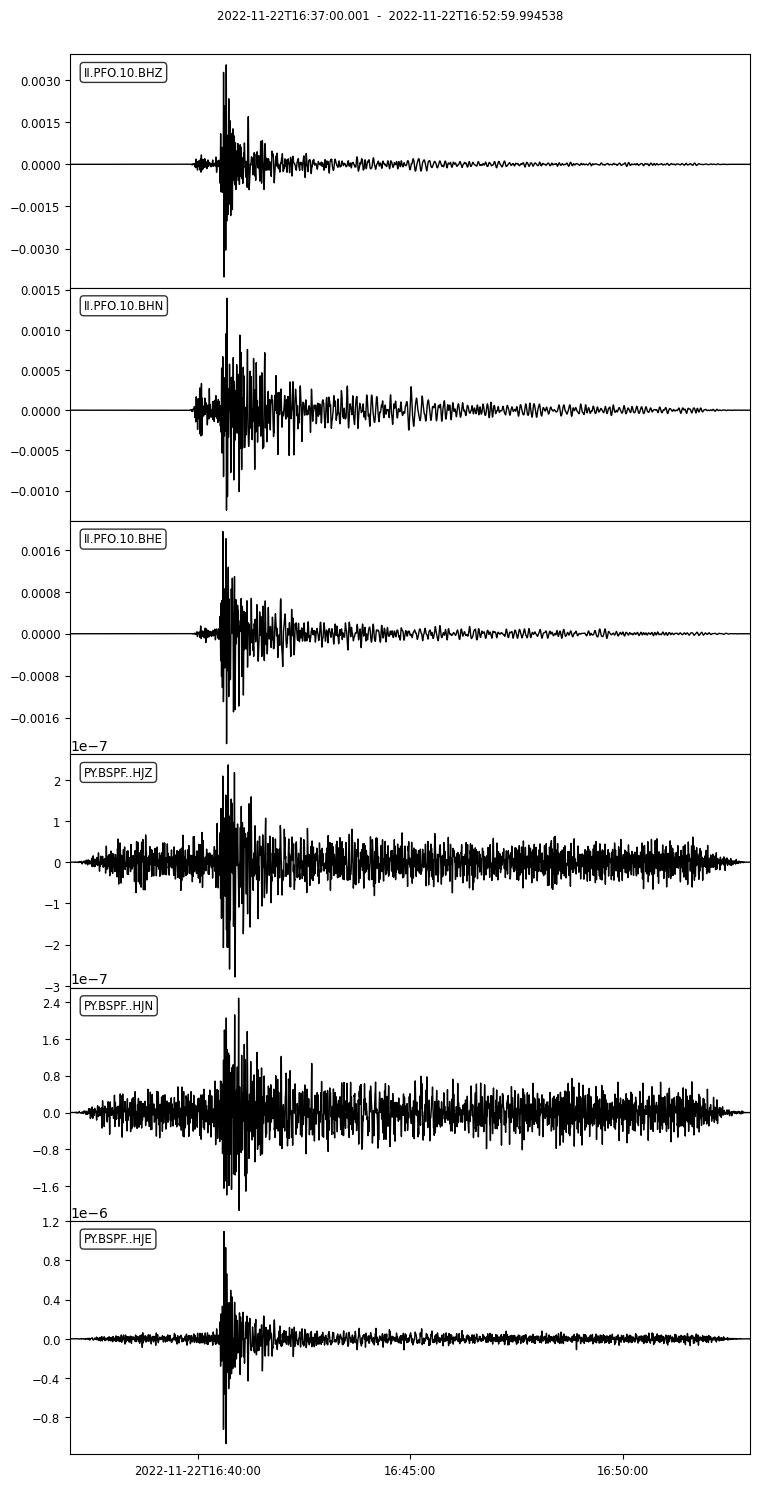

In [28]:
st.plot(equal_scale=False);

## Backazimuth

In [30]:
from functions.compute_backazimuth import __compute_backazimuth

In [84]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

fmin, fmax = 0.2, 1.0

rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)
acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)


# acc.select(channel="*Z")[0].data *= -1
# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
PY.BSPF..HJN | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
PY.BSPF..HJZ | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples

3 Trace(s) in Stream:
II.PFO.10.BHN | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples
II.PFO.10.BHE | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples
II.PFO.10.BHZ | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples

In [85]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

## specify window length for baz estimation in seconds
config['win_length_sec'] = 1/fmin

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1

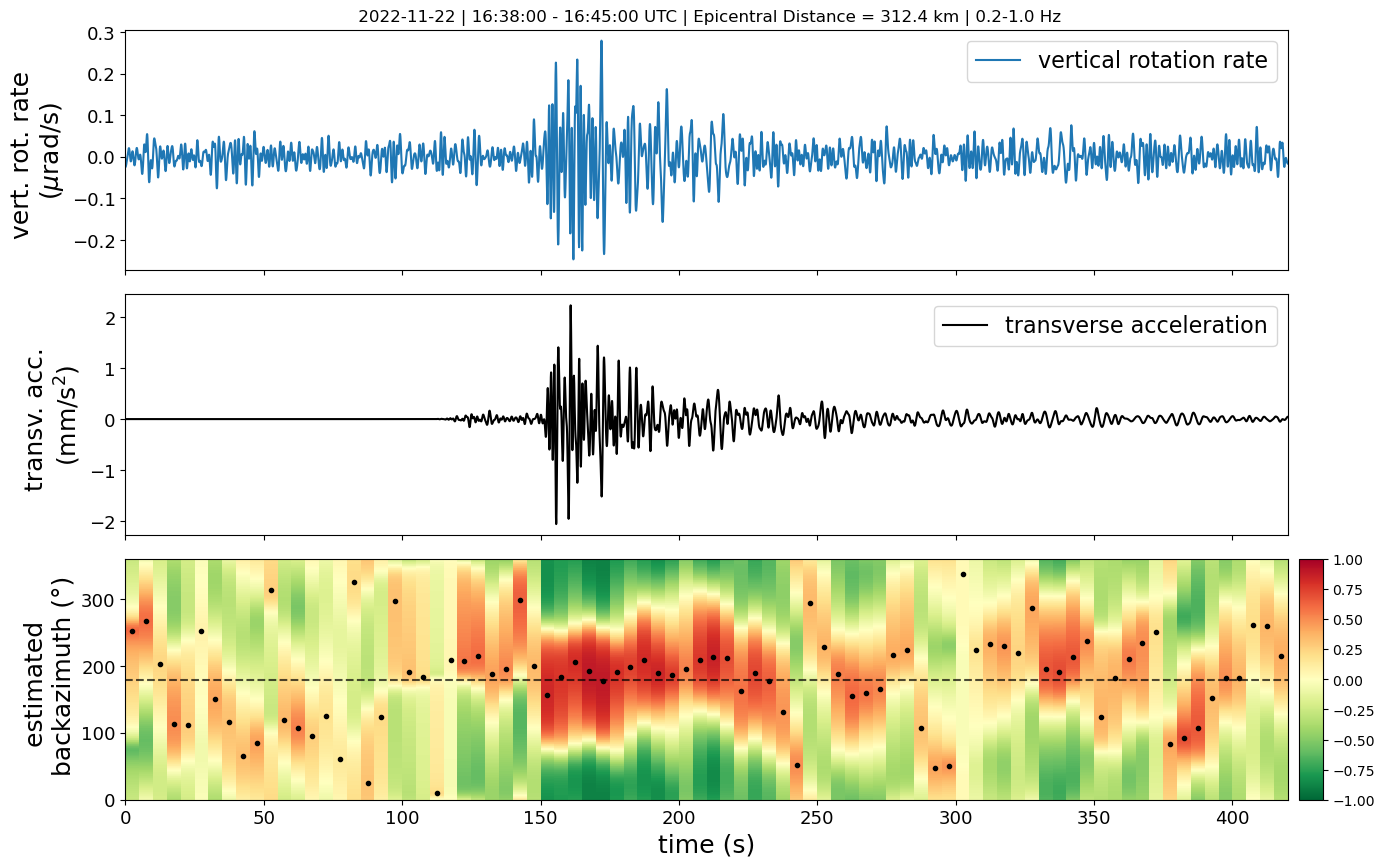

In [86]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='love',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
)

out['fig'].savefig(config['path_to_figs']+f"BSPF_M62_baz_love_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


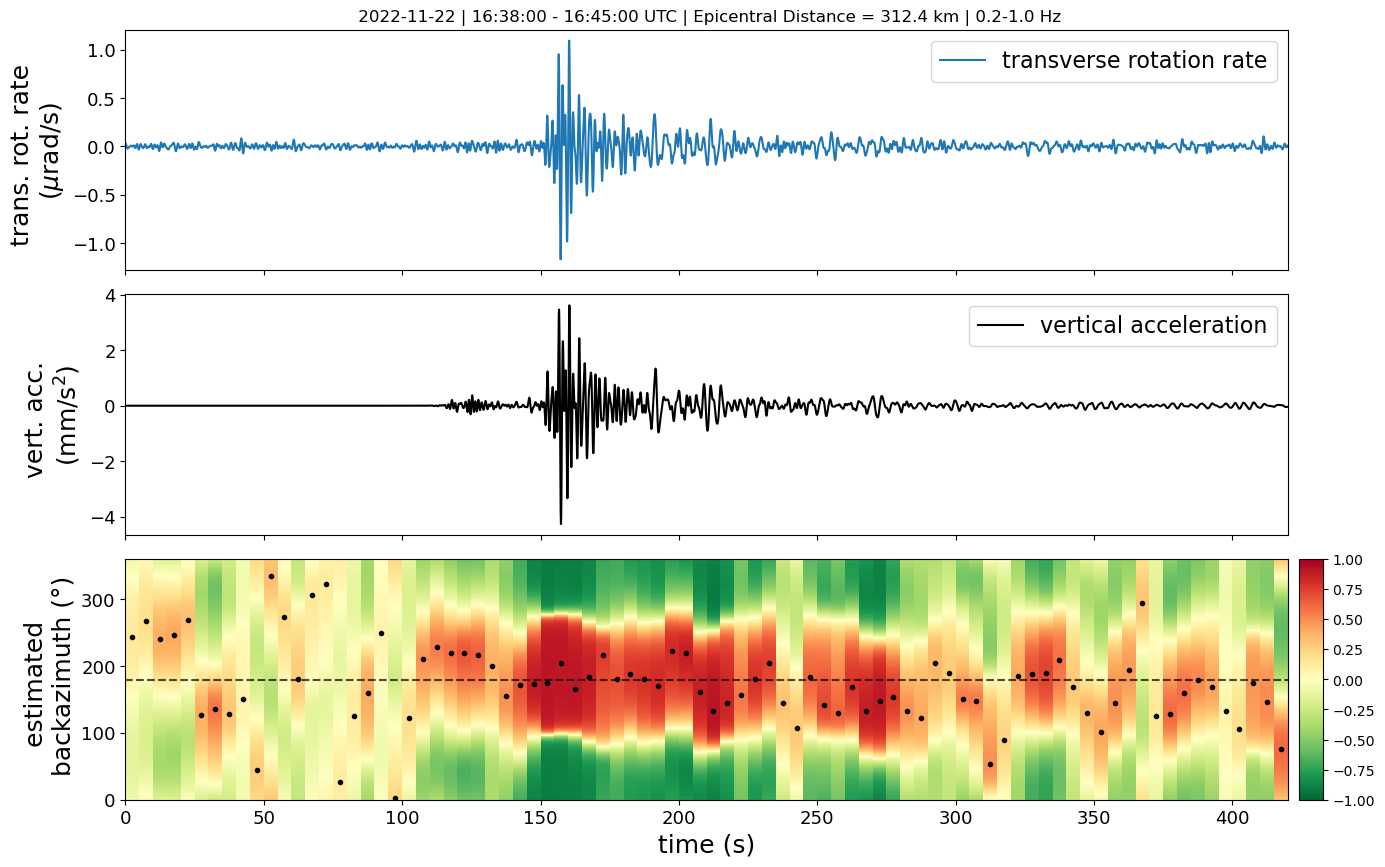

In [87]:
out = __compute_backazimuth(
                            acc,
                            rot,
                            config,
                            wave_type='rayleigh',
                            event=event,
                            plot=True,
                            flim=(fmin, fmax),
                            show_details=False,
)

out['fig'].savefig(config['path_to_figs']+f"BSPF_M62_baz_rayleigh_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


In [88]:
from functions.get_theoretical_backazimuth import __get_theoretical_backazimuth

In [14]:
config['event'] = event

baz, az, dist = __get_theoretical_backazimuth(config['BSPF_lat'], config['BSPF_lon'], event_obj=event, fdsn_client='USGS')

In [15]:
from functions.compute_backazimuth_tangent import __compute_backazimuth_tangent

In [16]:
# %load functions/compute_backazimuth_tangent.py
def __compute_backazimuth_tangent(rot0, acc0, win_time_s=0.5, overlap=0.5, baz_theo=None, cc_thres=None, plot=False):

    from numpy import zeros, nan, ones, nanmean, array, nanmax
    from numpy import arctan, pi, linspace, cov, argsort, corrcoef, correlate
    from obspy.signal.rotate import rotate_ne_rt
    from numpy.linalg import eigh
    from obspy.signal.cross_correlation import correlate
    import matplotlib.pyplot as plt

    npts = rot0[0].stats.npts

    df = rot0[0].stats.sampling_rate

    ## windows
    t_win = win_time_s
    n_win = int(win_time_s*df)
    nover = int(overlap*n_win)

    ## extract components
    rot_n = rot0.select(channel="*N")[0].data
    rot_e = rot0.select(channel="*E")[0].data
    acc_z = rot0.select(channel="*Z")[0].data

    ## define windows
    n, windows = 0, []
    while n < npts-n_win:
        windows.append((n,n+n_win))
        n+=n_win


    ## add overlap
    if overlap != 0:
        windows_overlap = []
        for i, w in enumerate(windows):
            if i == 0:
                windows_overlap.append((w[0],w[1]+nover))
            elif i >= int(len(windows)-nover):
                windows_overlap.append((w[0]-nover, w[1]))
            else:
                windows_overlap.append((w[0]-nover, w[1]+nover))
    else:
        windows_overlap = windows

    ## compute baz and ccorr for each window
    baz, ccor = ones(len(windows_overlap))*nan, ones(len(windows_overlap))*nan

    for j, (w1, w2) in enumerate(windows_overlap):

        if int(w2-w1) < 10:
            print(f" -> not enough samples in window (<10)")

        dat = (zeros((len(rot_n[w1:w2]), 2)))
        dat[:,0] = rot_e[w1:w2]
        dat[:,1] = rot_n[w1:w2]

        covar = cov(dat, rowvar=False)

        Cprime, Q = eigh(covar, UPLO='U')

        loc = argsort(abs(Cprime))[::-1]

        Q = Q[:,loc]

        baz0 = -arctan((Q[1,0]/Q[0,0]))*180/pi

        if baz0 <= 0:
            baz0 += 180

        ## __________________________
        ## remove 180° ambiguity

        rot_r, rot_t = rotate_ne_rt(rot_n[w1:w2], rot_e[w1:w2], baz0)

#         corr_baz = corrcoef(acc_z[w1:w2], rot_t)[0][1]
        corr_baz = correlate(acc_z[w1:w2], rot_t, 0, 'auto')[0]


        if (corr_baz > 0):
            baz0 += 180

        ## add new values to array
        if corr_baz > cc_thres:
            baz[j] = baz0
            ccor[j] = corr_baz

    ## define time axis
    t1 = array([w1/df for (w1, w2) in windows_overlap])
    t2 = array([w2/df for (w1, w2) in windows_overlap])

    time = array([((w2-w1)/2+w1)/df for (w1, w2) in windows_overlap])
    terr = (t2-t1)/2

    if plot:

        rot0, acc0 = rot_n, acc_z

        cmap = plt.get_cmap("viridis", 10)

        fig, ax = plt.subplots(1,1,figsize=(15,5))

        ax.plot(array(range(len(rot0)))/df, rot0/max(abs(rot0)), alpha=1, color="grey", label="rotation rate N (rad/s)")
        ax.plot(array(range(len(acc0)))/df, acc0/max(abs(acc0)), alpha=0.5, color="tab:red", label="acceleration Z (m/s)")


        ax.set_ylim(-1,1)
        ax.set_xlim(0, len(rot0)/df)
        ax.set_xlabel("Time (s)",fontsize=14)
        ax.set_ylabel("Norm. Amplitude",fontsize=14)
        ax.grid(zorder=0)
        ax.legend(loc=4, fontsize=13)

        ax2 = ax.twinx()
        cax = ax2.scatter(time, baz, c=ccor, s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ax2.errorbar(time, baz, xerr=terr, yerr=None, zorder=1, color="lightgrey", marker='o', markersize=2, ls="None")
        ax2.set_ylabel("Backazimuth (°)", fontsize=14)
        ax2.set_ylim(0, 360)
        ax2.set_yticks(linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))

        cbar = plt.colorbar(cax, pad=0.08)
        cbar.set_label("Cross-Correlation Coefficient", fontsize=14)

        cax.set_clip_on(False)

        if baz_theo:
            ax2.axhline(baz_theo, ls=":",c="k")

        plt.show();

        out = {"time":time, "baz_est":baz, "ccoef":ccor, "baz_theo":baz_theo, "fig":fig}
    else:
        out = {"time":time, "baz_est":baz, "ccoef":ccor, "baz_theo":baz_theo}

    return out

In [95]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

fmin, fmax = .1, .5

rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)
acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)


acc.select(channel="*Z")[0].data *= -1
# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
PY.BSPF..HJN | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
PY.BSPF..HJZ | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples

3 Trace(s) in Stream:
II.PFO.10.BHN | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples
II.PFO.10.BHE | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples
II.PFO.10.BHZ | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples

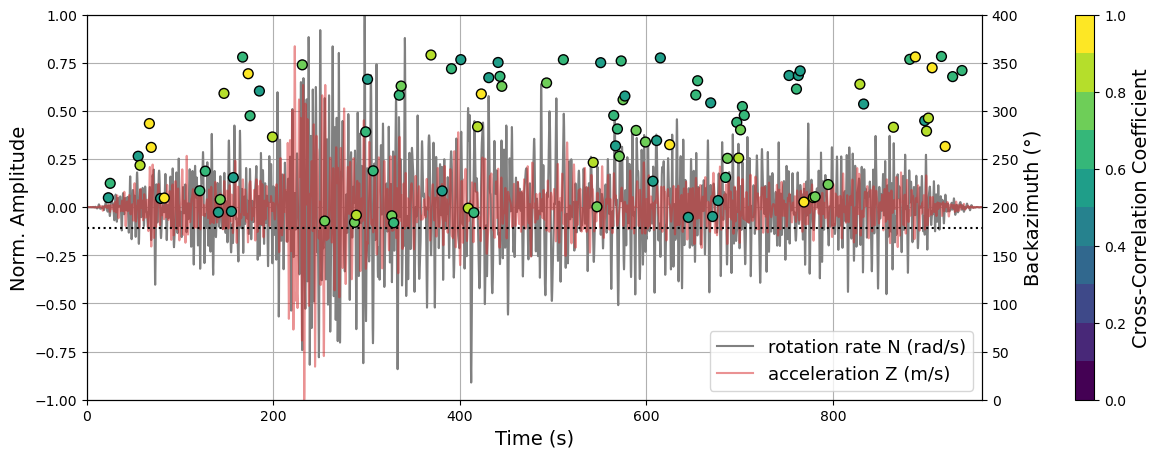

In [96]:
out = __compute_backazimuth_tangent(
                                    rot,
                                    acc,
                                    win_time_s=.2/fmin,
                                    overlap=0.5,
                                    baz_theo=baz,
                                    cc_thres=0.5,
                                    plot=True,
                                    )

out['fig'].savefig(config['path_to_figs']+f"BSPF_M62_baz_tangent_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

## Velocity

In [19]:
from functions.compute_velocity_from_amplitude_ratio import __compute_velocity_from_amplitude_ratio

In [20]:
acc = st0.select(station="PFO*").copy()
rot = st0.select(station="BSPF").copy()

fmin, fmax = 0.1, 0.5

rot.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)
acc.detrend("demean").taper(0.1).filter("bandpass", freqmin=fmin, freqmax=fmax, zerophase=True, corners=8)


# acc.select(channel="*Z")[0].data *= -1
# rot.select(channel="*Z")[0].data *= -1
# rot.select(channel="*E")[0].data *= -1
# rot.select(channel="*N")[0].data *= -1

3 Trace(s) in Stream:
PY.BSPF..HJE | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
PY.BSPF..HJN | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples
PY.BSPF..HJZ | 2022-11-22T16:37:00.001000Z - 2022-11-22T16:52:59.976000Z | 40.0 Hz, 38400 samples

3 Trace(s) in Stream:
II.PFO.10.BHN | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples
II.PFO.10.BHE | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples
II.PFO.10.BHZ | 2022-11-22T16:37:00.019538Z - 2022-11-22T16:52:59.994538Z | 40.0 Hz, 38400 samples

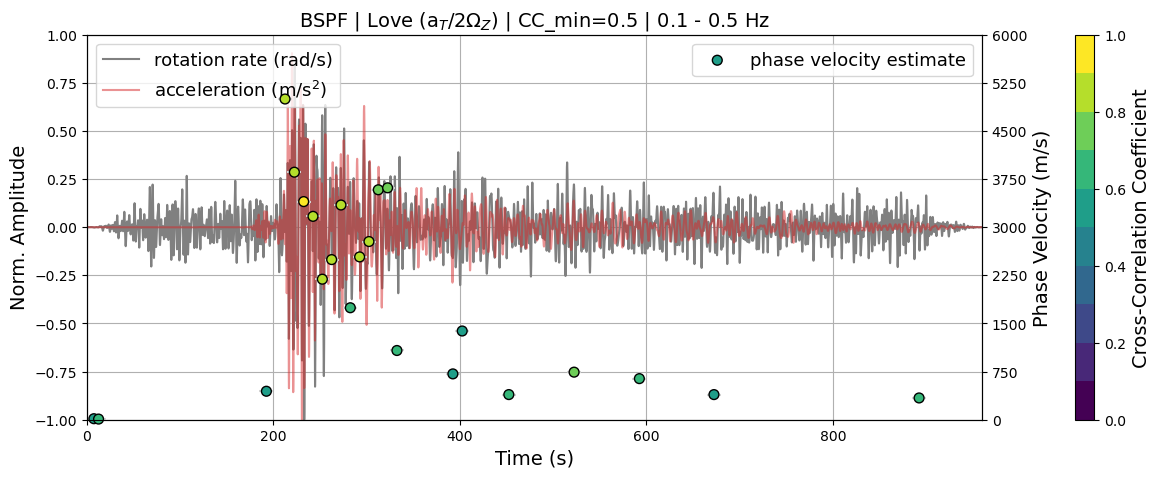

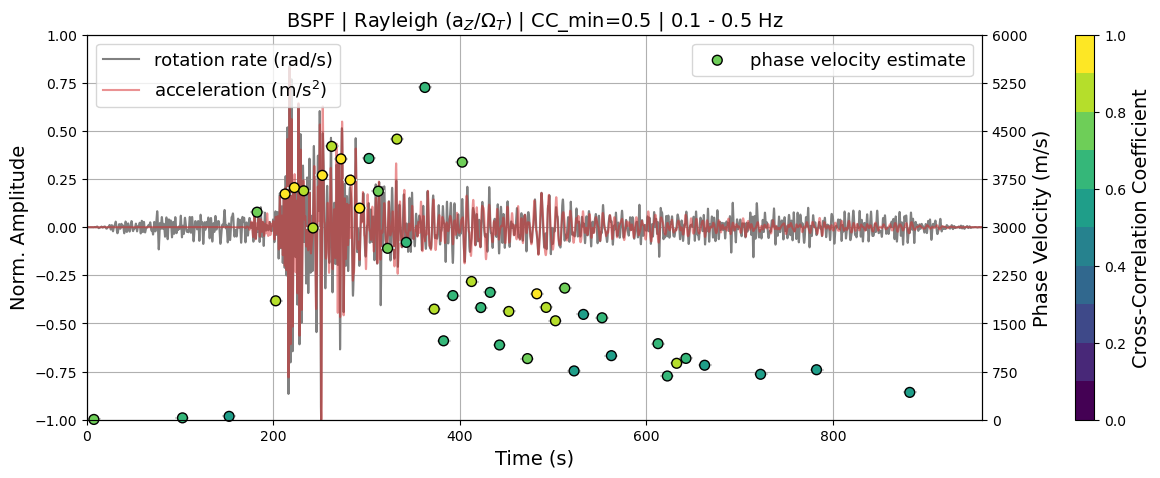

In [21]:
out = __compute_velocity_from_amplitude_ratio(
                                                rot,
                                                acc,
                                                baz=baz,
                                                mode='love',
                                                win_time_s=1/fmin,
                                                cc_thres=0.5,
                                                overlap=0.5,
                                                flim=(fmin, fmax),
                                                plot=True,
)
out['fig'].savefig(config['path_to_figs']+f"BSPF_M62_velocity_love_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


out = __compute_velocity_from_amplitude_ratio(
                                                rot,
                                                acc,
                                                baz=baz,
                                                mode='rayleigh',
                                                win_time_s=1/fmin,
                                                cc_thres=0.5,
                                                overlap=0.5,
                                                flim=(fmin, fmax),
                                                plot=True,
)
out['fig'].savefig(config['path_to_figs']+f"BSPF_M62_velocity_rayleigh_{fmin}_{fmax}.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


# 